In [25]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import os

# Paramentros del Modelo

In [26]:
# Intervalos de las variables parametricas
parameters_min = [0, 1.42, 0.142] # t, a, b
parameters_max = [60, 1.43, 0.143] # t, a, b

# Cantidad de valores para entrenar en cada epoca dentro del rango correspondiente
numbers_of_var = [230, 230, 230] # ti, ai, bi

# Condiciones Iniciales
x0 = [1 - 1e-1, 1e-1, 0, 0] # s0, i0, r0, t0
N = 1

# Sistema de Funciones (Derivadas)
y = [
    lambda t, s, i: -t[:, 1] * s * i,
    lambda t, s, i: t[:, 1] * s * i - t[:, 2] * i,
    lambda t, s, i: t[:, 2] * i
]

if len(parameters_min) != len(parameters_max) or len(parameters_max) != len(numbers_of_var):
    raise Exception("Debe asignar valores minimos, maximos y cantidad de samples para cada epoca de entrenamiento, para cada paramentro del sistema incluyendo t")

if len(y) != len(x0) - 1:
    raise Exception("Debe asiganr una condicion inicial para cada ecuacion del sistema mas una para t0")



# Modelo

In [27]:
n_in = len(
    numbers_of_var
)  # El número de entradas depende de los parámetros de las funciones
n_out = len(
    y
)  # El número de salidas corresponde a la cantidad de ecuaciones del sistema

# Perceptrón multicapa
Ns = nn.Sequential(
    nn.Linear(n_in, 100, bias=True),
    nn.Sigmoid(),
    nn.Linear(100, n_out, bias=True),
)
Ns = Ns.double()

# Solución paramétrica que garantiza la condición inicial


# Psi = [(lambda t: x0[copy(i)] + (t[:, 0] - x0[-1]) * Ns(t)[:, copy(i)]) for i in range(len(y))]

Psi = [lambda t, i=i: x0[i] + (t[:, 0] - x0[-1]) * Ns(t)[:, i] for i in range(len(y))]

# Criterio de mínimos cuadrados en la función de pérdida
criterion = torch.nn.MSELoss()
# Descenso gradiente (Propagación hacia atrás resiliente)
optimizer_s = torch.optim.Rprop(Ns.parameters(), lr=0.005)

# Se inicializa un rango de entrenamiento con valores de t cercanos para que el aprendizaje de la red sea más objetivo
xi = [
    np.random.uniform(parameters_min[i], parameters_max[i], numbers_of_var[i])
    for i in range(len(numbers_of_var))
]

t = torch.empty((numbers_of_var[0], 0))
# Creación de un tensor con todos los parámetros de las funciones

for i in range(len(numbers_of_var)):
    t = np.insert(t, t.shape[1], xi[i], 1)

t = torch.Tensor(t).double()


# Función de Pérdida
def loss(t):
    t.requires_grad = True
    outputs = [Psi[i](t) for i in range(len(y))]

    grads = [
        torch.autograd.grad(
            outputs[i], t, grad_outputs=torch.ones_like(outputs[i]), create_graph=True
        )[0]
        for i in range(len(y))
    ]

    criterio = sum(
        [
            criterion(grads[i][:, 0], y[i](t, outputs[0], outputs[1]))
            for i in range(len(y))
        ]
    )  # Suma de los mínimos cuadrados entre la evaluación en la derivada y los valores de la red por cada ecuación
    return criterio


# Clausura (uso del optimizador)
def closure_s():
    # Nuevo conjunto por cada iteración
    xi = [
        np.random.uniform(parameters_min[i], parameters_max[i], numbers_of_var[i])
        for i in range(len(numbers_of_var))
    ]

    t = torch.empty((numbers_of_var[0], 0))
    # Creación de un tensor con todos los parámetros de las funciones

    for i in range(len(numbers_of_var)):
        t = np.insert(t, t.shape[1], xi[i], 1)

    t = torch.Tensor(t).double()

    optimizer_s.zero_grad()
    ls = loss(t)  # Evaluación en la función de pérdida
    ls.backward()  # Propagación hacia atrás resiliente
    return ls

# Entrenamiento

In [28]:

# Iterando para optimizar
er_s = torch.inf
epochs = 10000
for e in range(epochs):
    er_s = optimizer_s.step(closure_s)
    print(f"epoch: {e +1}: {er_s}")


epoch: 1: 34770.19975417195
epoch: 2: 439.3246883950183
epoch: 3: 16331.05340036496
epoch: 4: 125.93089224505923
epoch: 5: 19.51307401524558
epoch: 6: 215.20795653938927
epoch: 7: 198.68502456282783
epoch: 8: 9.124161099566642
epoch: 9: 13.532659376219884
epoch: 10: 0.7142640818518347
epoch: 11: 0.030842544168461463
epoch: 12: 5.14634572393665
epoch: 13: 4.483395442735223
epoch: 14: 0.18476517810521575
epoch: 15: 0.04738017779110912
epoch: 16: 0.04783898694860009
epoch: 17: 0.015117558786720109
epoch: 18: 0.304223231251706
epoch: 19: 0.29342223664126077
epoch: 20: 0.03028102275563645
epoch: 21: 0.010313222179699492
epoch: 22: 0.010834971461964524
epoch: 23: 0.008519430275888074
epoch: 24: 0.011709837902079155
epoch: 25: 0.009552755042649363
epoch: 26: 0.008256126300647166
epoch: 27: 0.006807747698789132
epoch: 28: 0.006191539757431182
epoch: 29: 0.00534838638286423
epoch: 30: 0.005383952223295086
epoch: 31: 0.004985065132144475
epoch: 32: 0.004367595035913998
epoch: 33: 0.0044275782232

# Cargar Modelo

In [31]:
file_name = input("Nombre del archivo: ")
Ns.load_state_dict(torch.load(f'./models/{file_name}.pth' ))

C:\Users\emrys\AppData\Local\Temp\ipykernel_21516\1919552836.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Ns.load_state_dict(torch.load(f'./models/{file_name}.pth' ))

<All keys matched successfully>

# Evaluación

<>:53: SyntaxWarning: invalid escape sequence '\%'
<>:53: SyntaxWarning: invalid escape sequence '\%'
C:\Users\emrys\AppData\Local\Temp\ipykernel_21516\2198909160.py:53: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel("$Personas(\%)$")


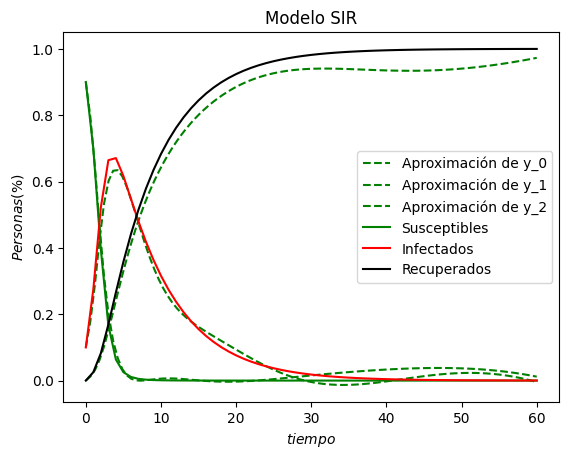

In [32]:
# Fase de Prueba
alpha = 1.4247
beta = 0.14286
xi[0] = torch.linspace(0, 60, 100)
xi[1] = np.full(100, alpha)
xi[2] = np.full(100, beta)

tt = torch.empty((100, 0))

for i in range(len(y)):
    tt = np.insert(tt, tt.shape[1], xi[i], 1)
tt = torch.Tensor(tt)

with torch.no_grad():
    s = [Psi[i](torch.Tensor(tt).double()) for i in range(len(y))]

fig, ax = plt.subplots(dpi=100)
for i in range(len(y)):
    ax.plot(xi[0], s[i] * N, "--", color="green", label=f'Aproximación de y_{i}')

# Comprobación con la función real
import scipy.integrate as spi

# Condiciones Iniciales
alpha = 1.4247
beta = 0.14286
x0[0] = 1 - 1e-1
x0[1] = 1e-1
x0[-1] = 0.0
N = 1
inp = (x0[0], x0[1], x0[-1])

def diff_eqs(INP, t):
    y = np.zeros((3))
    s, i, _ = INP
    y[0] = -alpha * s * i
    y[1] = alpha * s * i - beta * i
    y[2] = beta * i
    return y

t_start = 0.0
t_end = parameters_max[0]
t_inc = 1.0
t_range = np.arange(t_start, t_end + t_inc, t_inc)
sir = spi.odeint(diff_eqs, inp, t_range)

# Gráfica Real
ax.plot(sir[:, 0] * N, "-g", label="Susceptibles")
ax.plot(sir[:, 1] * N, "-r", label="Infectados")
ax.plot(sir[:, 2] * N, "-k", label="Recuperados")
plt.title("Modelo SIR")
ax.set_xlabel("$tiempo$")
ax.set_ylabel("$Personas(\%)$")
plt.legend(loc="best")
plt.show()

# Persistencia

In [6]:
file_name = input("Nombre del archivo: ")
if os.path.exists(f"./models/{file_name}.pth"):
    override = input(
        "Existe un archivo con el mismo nombre. ¿Lo desea sorbeescribir? (Y/N)"
    )
    if override.lower() == "n":
        file_name = file_name + " (2)"

torch.save(Ns.state_dict(), f"./models/{file_name}.pth")